In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense,Input, Dropout, Flatten, Conv2D, MaxPool2D,Reshape,GlobalAveragePooling2D
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization,Activation

from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers

In [2]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
print(x_train.shape)
print(y_train.shape)

(8012, 75, 100, 3)
(8012, 7)


# Step 10 : Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [3]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [4]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Step 11: Model Building 
# CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [5]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
num_classes = 7
K.set_learning_phase(0)
Inp = Input((75, 100, 3))
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(75, 100, 3))
K.set_learning_phase(1)
x = base_model(Inp)
x = GlobalAveragePooling2D(name='average_pool')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001), )(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = BatchNormalization(name='bn_fc_01')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=Inp, outputs=predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
resnet50 (Model)             (None, 3, 4, 2048)        23587712  
_________________________________________________________________
average_pool (GlobalAverageP (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

# Step 12: Setting Optimizer and Annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.
We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".
The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.
I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

# Data Augmentation
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations 

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [6]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

For the data augmentation, i choosed to :
Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height 
Once our model is ready, we fit the training dataset .

# Step 13: Fitting the model
In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs   as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train 

In [8]:
# Fit the model
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"skin_copy_model.h5")
callbacks = [
    learning_rate_reduction,
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
]
epochs = 50
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                             ,callbacks=callbacks ,class_weight = 'auto')

Epoch 1/50
721/721 [==============================] - 174s 242ms/step - loss: 1.4508 - acc: 0.6205 - val_loss: 2.3112 - val_acc: 0.6022
Epoch 2/50
721/721 [==============================] - 174s 241ms/step - loss: 1.2866 - acc: 0.6584 - val_loss: 2.0279 - val_acc: 0.6521
Epoch 3/50
721/721 [==============================] - 173s 240ms/step - loss: 1.2391 - acc: 0.6564 - val_loss: 1.6298 - val_acc: 0.6446
Epoch 4/50
721/721 [==============================] - 174s 242ms/step - loss: 1.1547 - acc: 0.6645 - val_loss: 1.1187 - val_acc: 0.6334
Epoch 5/50
721/721 [==============================] - 174s 241ms/step - loss: 1.0997 - acc: 0.6642 - val_loss: 1.0275 - val_acc: 0.6696
Epoch 6/50
721/721 [==============================] - 175s 243ms/step - loss: 1.0608 - acc: 0.6652 - val_loss: 1.0031 - val_acc: 0.6983
Epoch 7/50
721/721 [==============================] - 183s 253ms/step - loss: 1.0381 - acc: 0.6603 - val_loss: 3.4117 - val_acc: 0.5337
Epoch 8/50
721/721 [============================

721/721 [==============================] - 173s 240ms/step - loss: 0.7403 - acc: 0.7376 - val_loss: 1.3682 - val_acc: 0.6771
Epoch 50/50
721/721 [==============================] - 171s 237ms/step - loss: 0.7397 - acc: 0.7393 - val_loss: 1.3551 - val_acc: 0.6833


# Step 14: Model Evaluation 
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [9]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("resnetmodel.h5")


2003/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

802/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Validation: accuracy = 0.683292  ;  loss_v = 1.819458
Test: accuracy = 0.679481  ;  loss = 1.845600


In [10]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

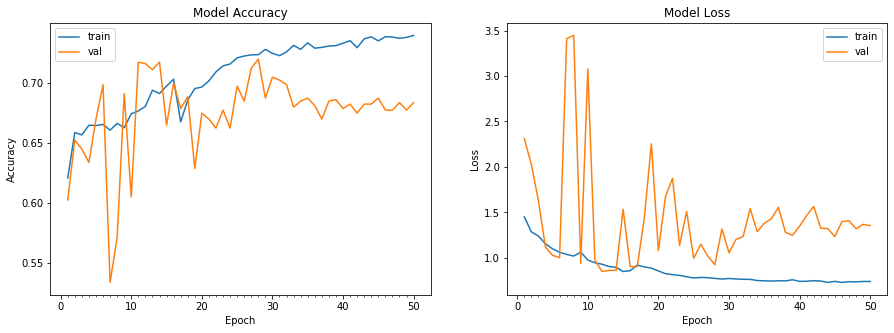

In [11]:
plot_model_history(history)

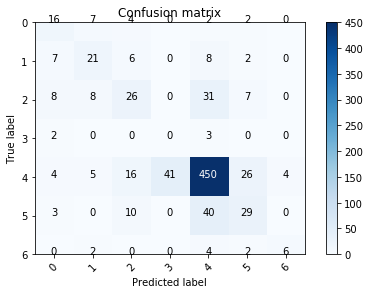

In [12]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Now, lets which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

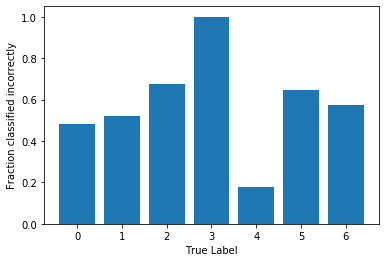

In [13]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Conclusion
It seems our model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code  0 where as Actinic keratoses code 4 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 80% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy 

I hope kagglers like my stepwise approach to classify cancer types. If like then kindly dont forget to hit the **like**
